# Introduction to the Magoptlib library

The Magoptlib Python library provides tools for the global spherical harmonic analysis such as calculating the spherical harmonics coefficients, calculating the field at various points using these coefficients and do coordinate system transformations.

## Import libraries

In [1]:
import magoptlib
from magoptlib import *
from magoptlib.magoptlib import get_sh_coeff, modified_sh, field_outside_sphere, sparse_isotropic_regularization
from magoptlib.visualization import create_fig
from magoptlib.load_text import text_to_array
from magoptlib.transformation import global_to_loc_spherical
import numpy as np
import matplotlib.pyplot as plt

## Global spherical harmonic analysis (GSHA) 

GSHA is the term to describe the reduction of global data sets to spherical harmonic (SH) coefficients. Mathematically it is similar to the inverse 2D Fourier transform on the sphere. During GSHA we estimate the coefficients from the signal. 

Each term of matrix B corresponds to a spherical harmonic evaluated at each sampled point in the working volume

$$
S(\theta, \phi)=\sum_{\ell=0}^{\infty} \sum_{m=-\ell}^{\ell} C_{\ell}^m Y_{\ell}^m(\theta, \phi)
$$

where $\theta \in [0, \pi ]$ and $\phi \in [0, 2\pi]$, and the associated Legendre polynomials $Y_{l}^{m}$:
$$
Y_{l}^{m}=(\theta, \phi)=(-1)^{\frac{m+\mid m \mid}{2}}\sqrt{\frac{(2l+1) \cdot (l-\mid m \mid)!}{4 \pi (l+ \mid m \mid)!}}P_l^{ \mid m \mid}(cos \theta) \cdot e^{i \cdot m(\phi + \pi)}
$$

We introduce a modified basis [1]:

$$
 Y_{j} =
    \begin{cases}
      \sqrt{2} \cdot Re(Y_{k}^{m}) & \text{if -k $\le$ m < 0}\\
      Y_k^0 & \text{if m=0 }\\
      \sqrt{2} \cdot Img(Y_{k}^{m}) & \text{if 0 < m $\le$ k}
    \end{cases} 
$$

The new basis is real and orthonormal. 

The modified signal equation rewritten in the new basis:

$$
S(\theta_i, \varphi_i)=\sum_{j=0}^{R} C_{j} Y_{j}(\theta_i, \phi_i)
$$

where :
- $S(\theta_i, \varphi_i), S:[N \times 1]$ is the SH signal, N is the number of (gradient) directions,
- $C_{j}, C: [R \times 1]$ is the SH coefficient, where $R=\frac{(l+1)(L+2)}{2} $ is the number of terms in the modified SH basis $Y$ of order $l$, 
- $Y_{j}(\theta_i, \phi_i)$ (in the code B) is the SH basis, $Y: [N \times R]$, 
- $l (l=0, 1, 2, ...)$: is the degree, which determines the complexity of the function in terms of the number of nodal lines, 
- $m (m=-l,...,+l)$ is the order, specifies the azimuthal variation within a given degree

$$
\left(\begin{array}{c}
S_{1} \\
S_{2} \\
S_{3} \\
\vdots \\
S_{R}
\end{array}\right)=
\left(\begin{array}{cccccc}
Y_{1}(\theta_1, \phi_1) & Y_{2}(\theta_1, \phi_1) & Y_{3}(\theta_1, \phi_1) & Y_{4}(\theta_1, \phi_1) & \cdots & Y_{R}(\theta_1, \phi_1) \\
Y_{1}(\theta_2, \phi_2) & Y_{2}(\theta_2, \phi_2) & Y_{3}(\theta_2, \phi_2) & Y_{4}(\theta_2, \phi_2) & \cdots & Y_{R}(\theta_2, \phi_2) \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
Y_{1}(\theta_N, \phi_N) & Y_{2}(\theta_N, \phi_N) & Y_{3}(\theta_N, \phi_N) & Y_{4}(\theta_N, \phi_N) & \cdots & Y_{R}(\theta_N, \phi_N)
\end{array}\right)\left(\begin{array}{c}
c_{00} \\
c_{2 -2} \\
c_{2 -1} \\
c_{2 0} \\
c_{2 1} \\
\vdots \\
c_{l m}
\end{array}\right)
$$


# Test with synthetic dataset

Calculate the SH coefficients, and transform back to validate the results.

In [2]:
data = [
    [-6.93065382e-01, -5.30427539e-01,  4.88166982e-01],
    [ 1.56842541e-01,  4.85297831e-01,  8.60166514e-01],
    [-7.42780180e-01, -4.31503544e-01,  5.11939738e-01],
    [-3.38245095e-01, -3.50804300e-01,  8.73227690e-01],
    [ 8.45853777e-02, -4.84191015e-01,  8.70864154e-01],
    [-4.88420369e-05, -2.94479225e-04,  9.99999955e-01],
    [ 1.11021347e-01, -5.15277454e-01,  8.49801980e-01],
    [-1.31048711e-01, -3.49391762e-01,  9.27767014e-01],
    [ 6.17461576e-01, -4.14738250e-02,  7.85506922e-01],
    [-3.34446318e-01, -4.84401677e-01,  8.08393886e-01],
    [-2.09145002e-01, -5.35735403e-01,  8.18074536e-01],
    [-2.91995473e-01, -2.09972466e-01,  9.33086388e-01],
    [-8.01178854e-01,  5.62507805e-01,  2.04199443e-01],
    [ 5.57795002e-01,  1.64565550e-01,  8.13500409e-01],
    [-7.88780239e-01,  3.60456995e-01,  4.97892047e-01],
    [-3.93736865e-01, -7.04653367e-02,  9.16518367e-01],
    [ 1.07299861e-01,  3.12616305e-01,  9.43799653e-01],
    [-2.64782167e-01,  5.55133043e-01,  7.88490779e-01],
    [ 7.20953965e-01, -6.90714534e-01,  5.60251158e-02],
    [-1.91881434e-01,  8.83528067e-01,  4.27270020e-01],
    [ 5.83113549e-01, -3.32288023e-01,  7.41325339e-01],
    [-3.20675736e-01, -2.11233517e-02,  9.46953471e-01],
    [ 8.42159468e-02, -2.67222444e-01,  9.59947832e-01],
    [ 7.85834584e-01,  6.16174643e-01,  5.28471050e-02],
    [ 6.09510253e-02,  2.04681471e-02,  9.97930873e-01],
    [ 2.40419836e-02,  6.86286319e-01,  7.26934021e-01],
    [-4.80446709e-01, -1.96076356e-01,  8.54824557e-01],
    [-2.64360358e-01,  7.06041372e-01,  6.56977307e-01],
    [-2.20776949e-01,  9.36606125e-01,  2.72078123e-01],
    [ 1.36136674e-02,  1.37773948e-02,  9.99812408e-01],
    [ 7.34487521e-01,  1.65165121e-01,  6.58216199e-01],
    [ 4.31287179e-01,  7.88358019e-01,  4.38728849e-01],
    [-7.27794124e-01,  2.48062067e-01,  6.39359776e-01],
    [-5.24371257e-01, -4.70874672e-01,  7.09444732e-01],
    [-7.07113557e-02,  7.90075574e-01,  6.08917475e-01],
    [ 3.45343442e-01, -5.79632794e-02,  9.36684667e-01],
    [-7.89975413e-02, -1.86003334e-01,  9.79368239e-01],
    [-1.42533946e-01,  6.47637826e-01,  7.48498043e-01],
    [ 4.11109615e-01,  1.37137546e-01,  9.01211506e-01],
    [-4.54480537e-02,  5.50760174e-01,  8.33425285e-01],
    [-8.09656016e-01, -5.41870280e-01,  2.25463379e-01],
    [-8.93155143e-02, -7.13561973e-03,  9.95977822e-01],
    [-7.23314780e-02, -1.05886680e-02,  9.97324439e-01],
    [ 8.99902799e-01,  3.82148726e-01,  2.10088797e-01],
    [ 9.80400808e-01, -1.92460394e-01,  4.21100091e-02],
    [ 1.03064930e-01,  9.93334196e-01,  5.16216635e-02],
    [-3.09850583e-02, -8.06210604e-02,  9.96263103e-01],
    [-1.92425585e-01,  3.92757449e-01,  8.99285261e-01],
    [ 4.55426357e-01,  8.73499811e-01,  1.72002655e-01],
    [-6.34595887e-01,  7.22515526e-01,  2.74334422e-01],
    [ 5.26814035e-01,  5.82741773e-01,  6.18772170e-01],
    [ 1.08547357e-01, -7.26386772e-02,  9.91433858e-01],
    [ 1.04169610e-01, -4.33274617e-01,  8.95221648e-01],
    [-3.18560806e-02, -6.69812384e-01,  7.41846723e-01],
    [ 5.47191183e-01, -5.77628722e-01,  6.05744888e-01],
    [ 1.43927757e-01, -2.28869531e-01,  9.62758297e-01],
    [ 9.13897373e-01,  2.47465886e-01,  3.21795319e-01],
    [-7.58631200e-01, -4.25149541e-01,  4.93686713e-01],
    [-3.96851922e-01, -2.97936442e-01,  8.68183407e-01],
    [ 9.93780945e-02,  7.79554431e-02,  9.91991403e-01],
    [-1.84415916e-01,  1.88039912e-01,  9.64692574e-01],
    [ 1.99707931e-01, -1.59165935e-01,  9.66841739e-01],
    [-7.82689846e-01,  5.38584073e-01,  3.11967628e-01],
    [-1.76853068e-01,  4.26536156e-01,  8.87011781e-01],
    [-3.99816300e-02, -2.86429617e-01,  9.57266705e-01],
    [-1.52588675e-01,  2.15249176e-01,  9.64564404e-01],
    [-7.53735706e-02,  1.86525324e-01,  9.79554556e-01],
    [ 8.75332534e-01, -4.19897850e-01,  2.39747262e-01],
    [-8.16176350e-01,  5.76622874e-01,  3.69083624e-02],
    [-3.00084689e-01,  6.88426406e-01,  6.60316790e-01],
    [-1.70518534e-01,  2.57786914e-01,  9.51035928e-01],
    [ 7.55291808e-01,  2.33739389e-01,  6.12290930e-01],
    [ 5.71007498e-01, -4.65562807e-01,  6.76166924e-01],
    [ 4.25375125e-01, -4.16551240e-01,  8.03455704e-01],
    [ 8.65837016e-01, -4.84022385e-01,  1.26683037e-01],
    [-3.54300017e-01,  3.31800356e-01,  8.74288294e-01],
    [ 5.77260993e-01,  4.32612759e-01,  6.92543101e-01],
    [ 1.04605602e-01,  1.12229516e-01,  9.88161021e-01],
    [-4.63363400e-01, -2.01493965e-01,  8.62956860e-01],
    [-5.82963725e-01, -1.64916488e-01,  7.95585223e-01],
    [-3.88784643e-02, -5.53663452e-01,  8.31832463e-01],
    [ 9.12965469e-01,  5.75157426e-02,  4.03962859e-01],
    [-5.37597608e-01,  8.33461814e-01,  1.27789735e-01],
    [ 8.28568481e-01,  4.48968884e-01,  3.34516387e-01],
    [ 9.57117160e-01, -1.73728506e-01,  2.31829999e-01],
    [-2.73250526e-01,  2.31261883e-01,  9.33730203e-01],
    [-5.06243146e-01,  2.18955495e-01,  8.34132105e-01],
    [ 3.04102163e-01, -3.15909910e-01,  8.98734000e-01],
    [ 5.77389007e-01,  4.37088672e-01,  6.89619771e-01],
    [-3.94840042e-01, -5.38142557e-01,  7.44650206e-01],
    [-2.67539404e-01,  1.29713115e-01,  9.54775982e-01],
    [ 6.12969905e-01, -5.75813656e-01,  5.41023593e-01],
    [-6.35592899e-01,  4.62004939e-01,  6.18524941e-01],
    [-5.99854519e-02,  6.96724105e-01,  7.14826739e-01],
    [ 5.01733221e-01, -3.00979000e-01,  8.10971896e-01],
    [ 2.81735278e-01, -4.19315008e-01,  8.63018051e-01],
    [ 1.21666881e-01,  2.86756138e-01,  9.50246330e-01],
    [ 8.68551778e-01, -4.29372631e-01,  2.47501417e-01],
    [ 4.23231759e-01, -3.36967944e-01,  8.41027635e-01],
    [-3.50677219e-01, -3.80901857e-01,  8.55534490e-01]
]

#create b values, where b goes from cos(0) until cos(pi)
angles = np.linspace(0, 4*np.pi, 200)
b_values = -1*np.cos(angles)
# add some noise to the b values
b_values = b_values + np.random.normal(0, 0.05, len(b_values))

# Create 200 data points
coords = np.array(data)
coords= np.vstack((coords, -coords))

# Calculate theta (polar angle) using arctan2
theta_values = np.arctan2(np.sqrt(coords[:, 0]**2 + coords[:, 1]**2), coords[:, 2])

# Calculate phi (azimuthal angle)
phi_values = np.arctan2(coords[:, 1], coords[:, 0])
phi_values = np.mod(phi_values, 2 * np.pi)


x=coords[:,0]
y=coords[:,1]
z=coords[:,2]

Visualization of the measurement points

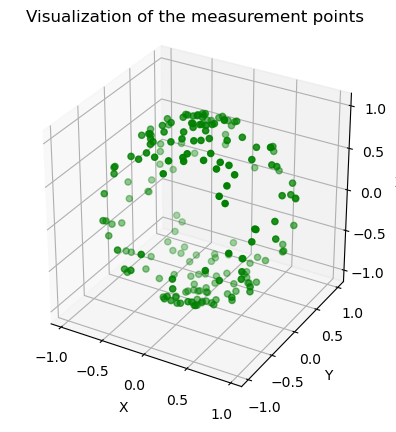

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'Visualization of the measurement points'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [3]:
create_fig(x, y, z)

Calculate the SH coefficients

In [4]:
# Calculate the spherical harmonics
real_sh, m_values, l_values = modified_sh(24, theta_values, phi_values)

# Calculate the spherical harmonics coefficients using Laplace-Beltrami and LASSO regularization
sh_coeff, inv_real_sh=get_sh_coeff(real_sh, m_values, l_values, b_values, smooth=0.0000001)
sh_coeff_sparse = sparse_isotropic_regularization(real_sh, b_values, 0.0000001)

# Calculate the field
sf = np.dot(real_sh, sh_coeff)
sf_sparse = np.dot(real_sh, sh_coeff_sparse)

Validation

In [5]:
# Calculate the mean squared error, root mean squared error, and mean absolute error for the Laplace-Beltrami regularization
mse = np.mean((b_values - sf) ** 2)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = np.mean(np.abs(b_values - sf))
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.0014624508491079514
Root Mean Squared Error: 0.03824200372768079
Mean Absolute Error: 0.010576368066067038


In [6]:
# Calculate the mean squared error, root mean squared error, and mean absolute error for the LASSO regularization
mse = np.mean((b_values - sf_sparse) ** 2)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = np.mean(np.abs(b_values - sf_sparse))
print("Mean Absolute Error:", mae)

Mean Squared Error: 1.917912535349564e-05
Root Mean Squared Error: 0.004379397830009925
Mean Absolute Error: 0.0012009934851597295


Plots

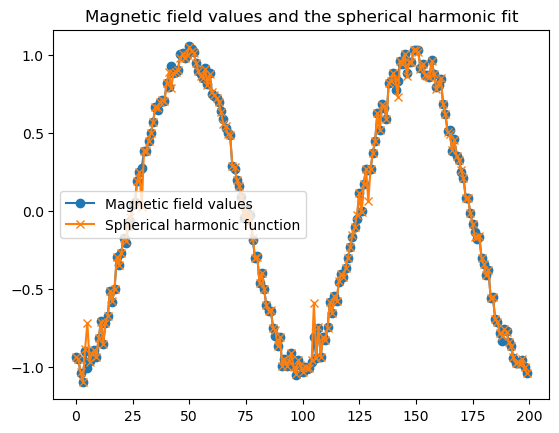

In [7]:
# plot the magnetic field values and the calculated function using Laplace-Beltrami regularization
plt.plot(b_values, label='Magnetic field values', marker='o')
plt.plot(sf, label='Spherical harmonic function', marker='x')
plt.title("Magnetic field values and the spherical harmonic fit")
plt.legend()
plt.show()

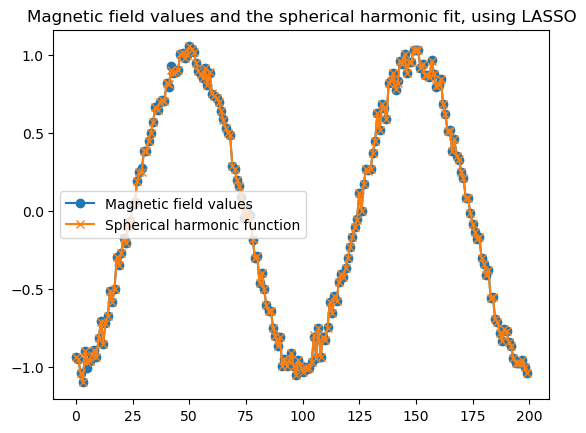

In [8]:
# plot the magnetic field values and the calculated function using LASSO regularization
plt.plot(b_values, label='Magnetic field values', marker='o')
plt.plot(sf_sparse, label='Spherical harmonic function', marker='x')
plt.title("Magnetic field values and the spherical harmonic fit, using LASSO")
plt.legend()
plt.show()

# Test with real dataset

Read the input file

In [21]:
b_values_r, phi_values_r, theta_values_r=text_to_array("test_simulation_cubic_magnet_12mm_3_randompolarisation.mag.pkl.mag.json")

Calculate the SH coefficients

In [22]:
# convert the data to numpy arrays
theta_values_r = np.asarray(theta_values_r)
phi_values_r = np.asarray(phi_values_r)

# Calculate the spherical harmonics
real_sh_r, m_values_r, l_values_r = modified_sh(24, theta_values_r, phi_values_r)

# Calculate the spherical harmonics coefficients using Laplace-Beltrami and LASSO regularization
sh_coeff_smooth, inv_real_sh_smooth=get_sh_coeff(real_sh_r, m_values_r, l_values_r, b_values_r, smooth=0.000001)
sh_lasso = sparse_isotropic_regularization(real_sh_r, b_values_r, 0.000001)

# Calculate the field
sf_smooth = np.dot(real_sh_r, sh_coeff_smooth)
sf_lasso = np.dot(real_sh_r, sh_lasso)

Validation

In [23]:
mse_smooth = np.mean((b_values_r - sf_smooth) ** 2)
print("Mean Squared Error:", mse_smooth)

rmse_smooth = np.sqrt(mse_smooth)
print("Root Mean Squared Error:", rmse_smooth)

mae_smooth = np.mean(np.abs(b_values_r - sf_smooth))
print("Mean Absolute Error:", mae_smooth)


Mean Squared Error: 0.0041436800228731
Root Mean Squared Error: 0.06437142240834128
Mean Absolute Error: 0.028456430324065057


In [12]:
mse_lasso = np.mean((b_values_r - sf_lasso) ** 2)
print("Mean Squared Error:", mse_lasso)

rmse_lasso = np.sqrt(mse_lasso)
print("Root Mean Squared Error:", rmse_lasso)

mae_lasso = np.mean(np.abs(b_values_r - sf_lasso))
print("Mean Absolute Error:", mae_lasso)

mse_percentage_mean_lasso = (mse_lasso / np.mean(b_values_r)) * 100
print(f"MSE as a percentage of the mean: {mse_percentage_mean_lasso} %")

Mean Squared Error: 0.004118170738112768
Root Mean Squared Error: 0.06417297513839271
Mean Absolute Error: 0.027561079652685047
MSE as a percentage of the mean: 7176.638161776636 %


plots

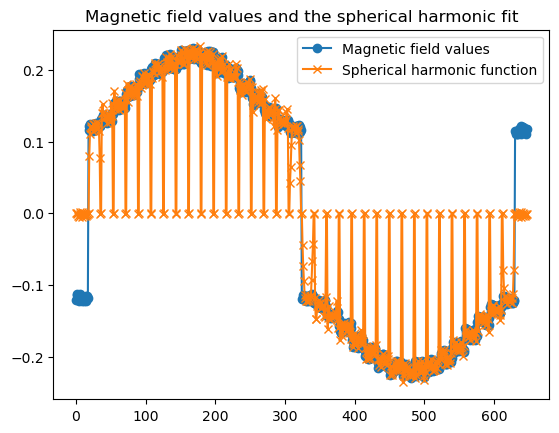

In [13]:
# plot the magnetic field values and the calculated function using Laplace-Beltrami regularization
plt.plot(b_values_r, label='Magnetic field values', marker='o')
plt.plot(sf_smooth, label='Spherical harmonic function', marker='x')
plt.title("Magnetic field values and the spherical harmonic fit")
plt.legend()
plt.show()

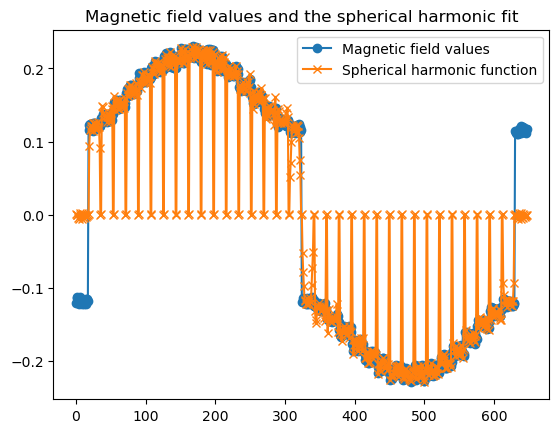

In [14]:
# plot the magnetic field values and the calculated function using LASSO regularization
plt.plot(b_values_r, label='Magnetic field values', marker='o')
plt.plot(sf_lasso, label='Spherical harmonic function', marker='x')
plt.title("Magnetic field values and the spherical harmonic fit")
plt.legend()
plt.show()

## Field outside sphere

For the region outside the sphere expressed in terms of spherical harmonics:

$$
S_{\textbf{out}}(\theta_i, \varphi_i)=\sum_{j=0}^{R} \left ( \frac{r_s}{r} \right ) ^{l+1} C_{j} Y_{j}(\theta_i, \phi_i),
$$


where $r_s$ is the radius of the sphere and $r$ is the radial distance of the point of interest [2], [3].

In [15]:
# calculate the spherical harmonics
real_sh_out, m_values_out, l_values_out = modified_sh(12, theta_values_r, phi_values_r)

# calculate the spherical harmonics coefficients
sh_coeff_out, inv_real_sh_out=get_sh_coeff(real_sh_out, m_values_out, l_values_out, b_values_r)

### For validation purposes, check whether we get back the same magnetic field value, if the radial distance equals to the radius

In [17]:
# get the eightieth value from theta_values_r and phi_values_r
theta_point = theta_values_r[80]
phi_point = phi_values_r[80]

# get the real spherical harmonic values for the point of interest
real_sh_out,_,_, _= field_outside_sphere(4, 4, theta_point, phi_point, 12)

# calculate the magnetic field value at the point of interest
sf_point = np.dot(real_sh_out, sh_coeff_out)

print(f"Calculated magnetic field value at the point of interest: ", sf_point)
print(f"Measured magnetic field value at the point of interest: ", b_values_r[80])
print(f"Percentage error: {((b_values_r[80] - sf_point) / b_values_r[80]) * 100} %")

Calculated magnetic field value at the point of interest:  [0.17413496]
Measured magnetic field value at the point of interest:  0.1739878839119271
Percentage error: [-0.08453267] %


### Calculate the magnetic field at a bigger radial distance

In [19]:
# get the real spherical harmonic values for the point, 
real_sh_bigger_out,_,_, _= field_outside_sphere(7, 4, theta_point, phi_point, 12)

# calculate the magnetic field value at the point of interest
sf_point_new = np.dot(real_sh_bigger_out, sh_coeff_out)

print(f"Calculated magnetic field value at the point of interest: ", sf_point_new)

Calculated magnetic field value at the point of interest:  [0.06026877]


## Coordinate system transformations

We can transform points between the global coordinate system to the local spherical coordinate systems using the global_to_loc_spherical function. To test it, calculate the coordinates of a point that is well known.

In [20]:
# point at (1, 0, 0), local coordinate system origin is at (0, 0, 0)
r_t, theta_t, phi_t = global_to_loc_spherical(1, 0, 0, 0, 0, 0)

# expected results
r_expected = 1
theta_expected =  np.pi/2
phi_expected = 0

# check if the results are as expected
print(f"r: {r_t == r_expected}")
print(f"theta: {theta_t == theta_expected}")
print(f"phi: {phi_t == phi_expected}")

r: True
theta: True
phi: True


References:


[1] Maxime Descoteaux et al. “Regularized, fast, and robust analytical Q-ball imaging”. In: Magnetic Resonance in Medicine 58.3 (2007), pp. 497–510.

[2] A Plattner and C Johnson. “Local spherical harmonic power spectra from local magnetic or gravity data”. In: Geophysical Journal International 236 (Dec. 2023).

[3] Nikolaos K. Pavlis. “Spherical Harmonic Analysis Applied to Potential Fields”. In: Encyclopedia of Solid Earth Geophysics. Ed. by Harsh K. Gupta. Cham: Springer International Publishing, 2020, pp. 1–11. ISBN: 978-3-030-10475-7.